# Introduction
Sleep disorders are conditions that affect the quality, amount, and timing of sleep that a person is able to get at night. Although there are over 80 different types of sleep disorders, two of the most common disorders include Insomnia and Obstructive Sleep Apnea <sup>1</sup>.

*   **Insomnia** is characterized by a difficulty falling and staying asleep.Individuals with insomnia tend to wake up several times throughout the night and typically wake up much earlier than desired. Individuals with Insomnia tend to experience excessive daytime drowsiness and impaired cognitive/motor function.  

*   **Obstructive Sleep Apnea (OSA)** is a sleep disorder characterized by repeated episodes of complete or partial blockage of the airway during sleep.When occlusion occurs, individuals are woken up to regain concisous control of the airway. As obstruction can occur several times throughout the night, individuals with OSA often experience fragmented sleep and may suffer from a number of negative symptoms including excessive daytime sleepiness, cognitive impairment, and decreased quality of life <sup>1</sup>.

# Project and purpose
In my project, I explore a dataset capturing details about sleep patterns, lifestyle habits, and related health indicators for 374 individuals with no sleep disorders, Sleep Apnea, or Insomnia. This dataset was generated for educational purposes, and as a result, contains **simulated** patient data based off of real patient demographics.

I first visualize the distribution and correlation between key variables. The purpose of this analysis is to compare this dataset to known trends in Insomnia and Obstructive Sleep Apnea to evaluate the fidelity of this dataset.

I then train a PyTorch Neural Network with two hidden layers to perform multiclass classification, with the goal of using sleep and lifestyle metrics to predict whether or not someone has Insomnia or Obstructive Sleep Apnea. Treating sleep disorders quickly after onset greatly reduces the severity of short- and long-term health problems that an individual experiences. Unfortunately, few people know the signs of sleep disorders, and thus, it is rare for idnividuals to seek medical help for sleep disorders in the early stages. A model, such as the one developed in this project, could be used to more quickly and more accurately screen individuals for sleep disorders, and encourage them to seek appropriate medical care.



*Data Source: https://www.kaggle.com/datasets/varishabatool/disorder*

# Section 1: Importing Dataset


---


The dataset above has been imported from kaggle and uploaded to Google Drive. This segment of the code loads this dataset as a pandas dataframe and cleans the dataset for downstream analysis. This section also imports all of the packages needed for this project.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset (previously uploaded to Google Drive)
path = '/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv'
sleep_data = pd.read_csv(path)

# Display the first five rows of the dataset
print(sleep_data.head())

# Check the shape and any missing values
print(f"\nDataset shape: {sleep_data.shape}") #first number represents the number of patients, second number represents the number of variables collected about each patient
missing_values = sleep_data.isnull().sum() #sums up the number of null/NaN values in each column
print("\nMissing values in each column:\n", missing_values)

Mounted at /content/drive
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200            NaN  
1       

In [ ]:
# Individuals with no sleep disorder are represented as 'NaN', which will impact downstream analysis.
# We replace 'NaN' with None
print('Prior to Cleanup, The Sleep Disorders Column takes on the following values: ',sleep_data['Sleep Disorder'].unique())
sleep_data['Sleep Disorder'] = sleep_data['Sleep Disorder'].fillna('None')
print('After Cleanup, The Sleep Disorders Column takes on the following values: ',sleep_data['Sleep Disorder'].unique())
print()

# We notice that the 'blood pressure' column is a string with systolic and diastolic pressure together
print(sleep_data[['Blood Pressure']].head())
print()

# Although both values are correlated, they are differentially sensitive to sleep disorders. Therefore
# We must seperate the two values.
bp_split = sleep_data['Blood Pressure'].str.split('/', expand=True) #splits values by / demarkation
sleep_data['Systolic BP'] = bp_split[0].astype(int)
sleep_data['Diastolic BP'] = bp_split[1].astype(int)
sleep_data = sleep_data.drop('Blood Pressure', axis=1) #Drops original column
print(sleep_data[['Systolic BP', 'Diastolic BP']].head())

#Drop Patient ID and Occupation Columns as they are not relevant to our characterization
sleep_data = sleep_data.drop(columns=['Person ID', 'Occupation'])

Prior to Cleanup, The Sleep Disorders Column takes on the following values:  [nan 'Sleep Apnea' 'Insomnia']
After Cleanup, The Sleep Disorders Column takes on the following values:  ['None' 'Sleep Apnea' 'Insomnia']

  Blood Pressure
0         126/83
1         125/80
2         125/80
3         140/90
4         140/90

   Systolic BP  Diastolic BP
0          126            83
1          125            80
2          125            80
3          140            90
4          140            90


# Section 2: Exploratory Data Analysis
Following initial data cleanup, we first explore the distribution of the lifestyle (Physical Activity level, stress level, daily steps) , sleep (sleep duration, quality of sleep) , and demographics (Age, Heart Rate, Systolic BP, Diastolic BP) information collected about each patient.

In [ ]:
#Prints the descriptive statistics of each variable.
print("Descriptive Statistics:\n", sleep_data.describe())

Descriptive Statistics:
               Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
count  374.000000      374.000000        374.000000               374.000000   
mean    42.184492        7.132086          7.312834                59.171123   
std      8.673133        0.795657          1.196956                20.830804   
min     27.000000        5.800000          4.000000                30.000000   
25%     35.250000        6.400000          6.000000                45.000000   
50%     43.000000        7.200000          7.000000                60.000000   
75%     50.000000        7.800000          8.000000                75.000000   
max     59.000000        8.500000          9.000000                90.000000   

       Stress Level  Heart Rate   Daily Steps  Systolic BP  Diastolic BP  
count    374.000000  374.000000    374.000000   374.000000    374.000000  
mean       5.385027   70.165775   6816.844920   128.553476     84.649733  
std        1.774526    4.1356

While OSA is more prevalent in men, Insomnia is more prevalent in women. The following code generates three pie charts: one showing overall gender distribution, one showing gender distribution for OSA, and one showing gender distriubtion for Insomnia.

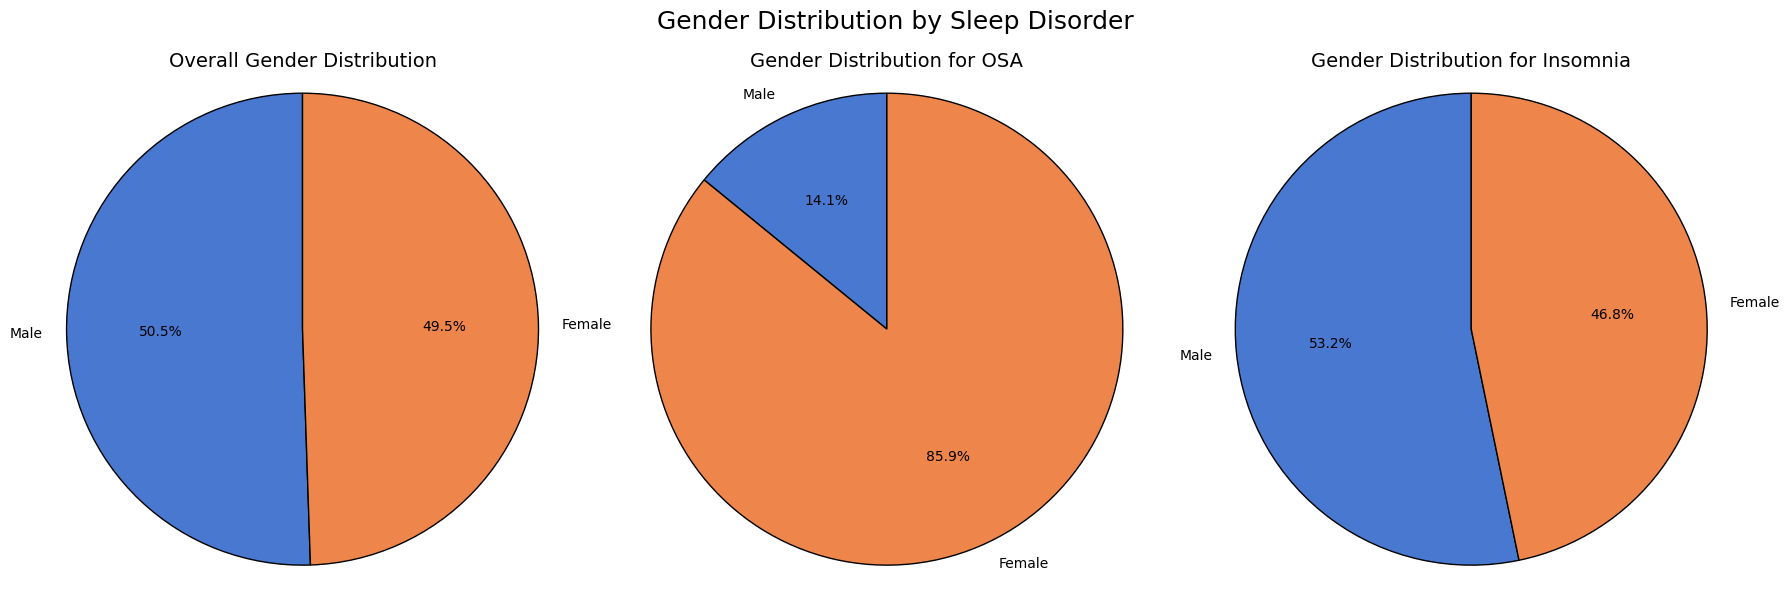

In [ ]:
category_order = ['Male', 'Female'] #Specifies a category order because otherwise, the genders are not consistently colored throughout the dataset.

#Calculates the proportion of males and females in each category
data_overall = sleep_data['Gender'].value_counts()
data_osa = sleep_data[sleep_data['Sleep Disorder'] == 'Sleep Apnea']['Gender'].value_counts()
data_insomnia = sleep_data[sleep_data['Sleep Disorder'] == 'Insomnia']['Gender'].value_counts()

#Creates a plot map like above, based on implementation strategies provided by seaborn help page (see citation at bottom of notebook)
plot_map = { 'Overall Gender Distribution': data_overall, 'Gender Distribution for OSA': data_osa, 'Gender Distribution for Insomnia': data_insomnia}

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Gender Distribution by Sleep Disorder', fontsize=18)

#Plots pie charts
for i, (title, counts) in enumerate(plot_map.items()):
    counts = counts.reindex(category_order)
    ax = axs[i]
    wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("muted"), wedgeprops={'edgecolor': 'black'})
    ax.set_title(title, fontsize=14)
    ax.axis('equal')

plt.tight_layout()
plt.show()

Both OSA and Insomnia are tend to affect older adults, typically those over the age of 65. We begin by exploring the distribution of patient ages. The following code generates a histogram of the age distribution within this dataset using the Seaborn library.

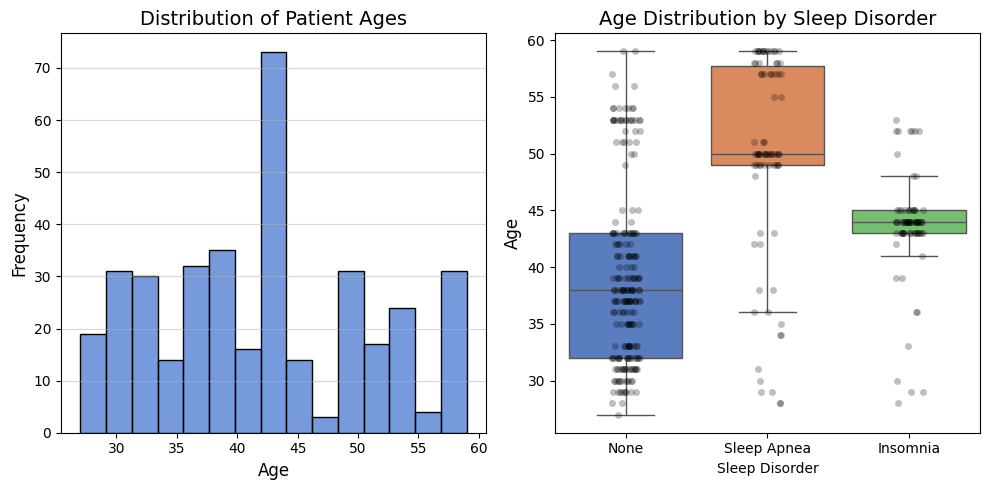

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.set_palette('muted')

#Generate age vs. frequency histogram
sns.histplot(sleep_data['Age'], bins=15, ax=axs[0], color = sns.color_palette("muted")[0]) #15 bins to provide sufficient granularity to visualize trend
axs[0].set_title(f'Distribution of Patient Ages', fontsize=14)
axs[0].set_xlabel('Age', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].grid(axis='y', alpha=0.5)

#Generate sleep disorder vs age box plots
disorder_order = ['None', 'Sleep Apnea', 'Insomnia']
sns.boxplot(x='Sleep Disorder', y='Age', data=sleep_data, order=disorder_order, showfliers=False, ax=axs[1], hue="Sleep Disorder") #Boxplots
sns.stripplot(x='Sleep Disorder', y='Age', data=sleep_data, order=disorder_order, size=5, jitter=True, color='black', alpha=0.25, ax=axs[1]) #Overlay datapoints
axs[1].set_title('Age Distribution by Sleep Disorder', fontsize=14)
axs[1].set_ylabel('Age', fontsize=12)

# Adjust layout to prevent subplots from overlapping
plt.tight_layout()
plt.show()

We then explore how key metrics like heart rate, systolic BP, and diastolic BP are distributed throughout the dataset. Each corresponding plot includes a red vertical line marking the upper limit of the clinically healthy range for that variable.

0% of patients are above threshold for Heart Rate
77% of patients are above threshold for Systolic BP
59% of patients are above threshold for Diastolic BP


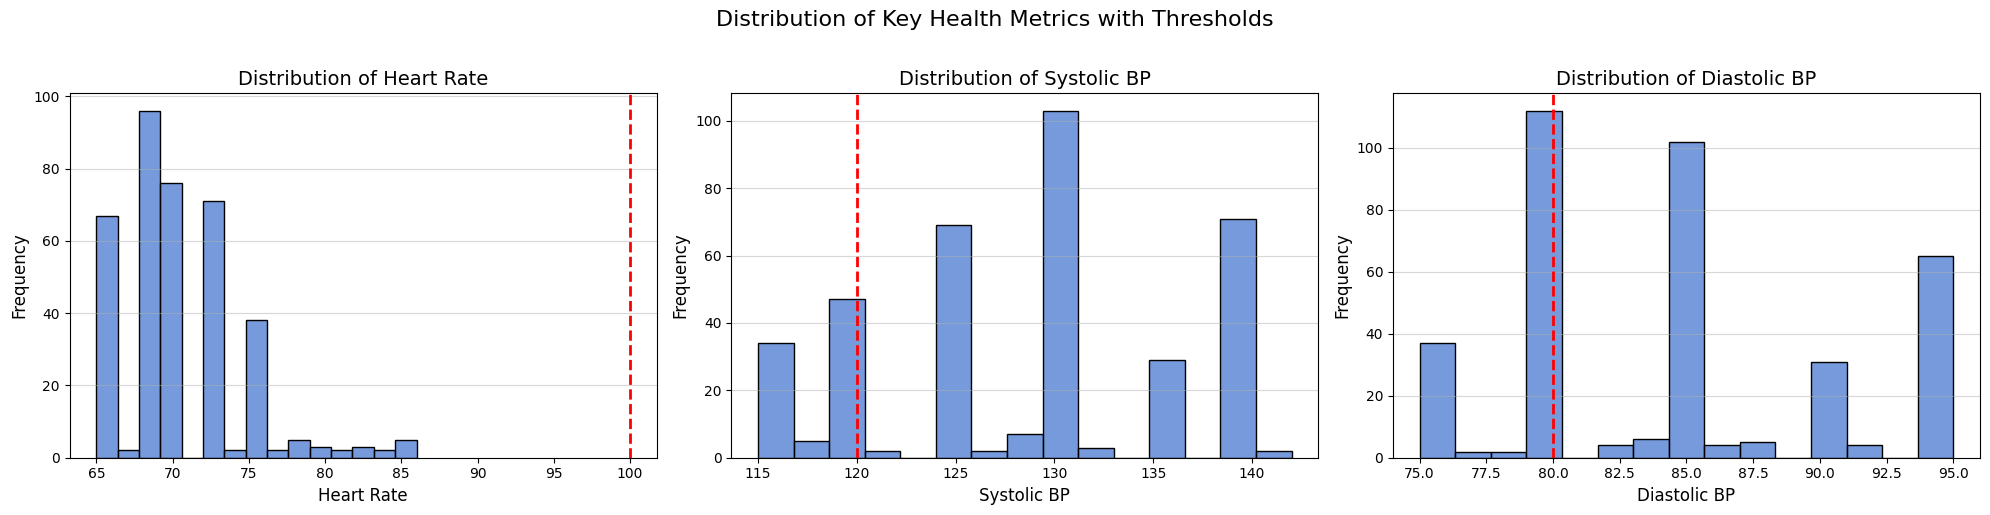

In [ ]:
plot_data = {'Heart Rate': 100, 'Systolic BP': 120, 'Diastolic BP': 80} #Dictionary containing variables to plot and corresponding "healthy" values

#Generates plots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('Distribution of Key Health Metrics with Thresholds', fontsize=16, y=1.02)

for i, (col, threshold) in enumerate(plot_data.items()):

    #Calculates the percentage of datapoints that are above the healthy threshold
    total_count = len(sleep_data[col])
    above_threshold_count = (sleep_data[col] > threshold).sum()
    percent_above = (above_threshold_count / total_count) * 100
    print(f'{percent_above:.0f}% of patients are above threshold for {col}')

    #Generates plots
    ax = axes[i]
    sns.histplot(sleep_data[col], bins=15, ax=ax) #Generates histogram for each variable
    ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold}') #adds vertical line at threshold

    # Formatting and Labels
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(axis='y', alpha=0.5)

plt.tight_layout()

We are particularly interested in the correlation between heart rate and diastolic BP. Although both variables are correlated (i.e., a higher heart rate = a higher diastolic BP), they are also independently associated with disordered sleep. In the early stages, sleep disorders tend to affect diastolic BP more than systolic BP. For instance, individuals with early-stage OSA experience an increase in diastolic BP without a corresponding increase in systolic BP. Therefore, we plot heart rate by diastolic BP, while coloring datapoints by Sleep Disorder.

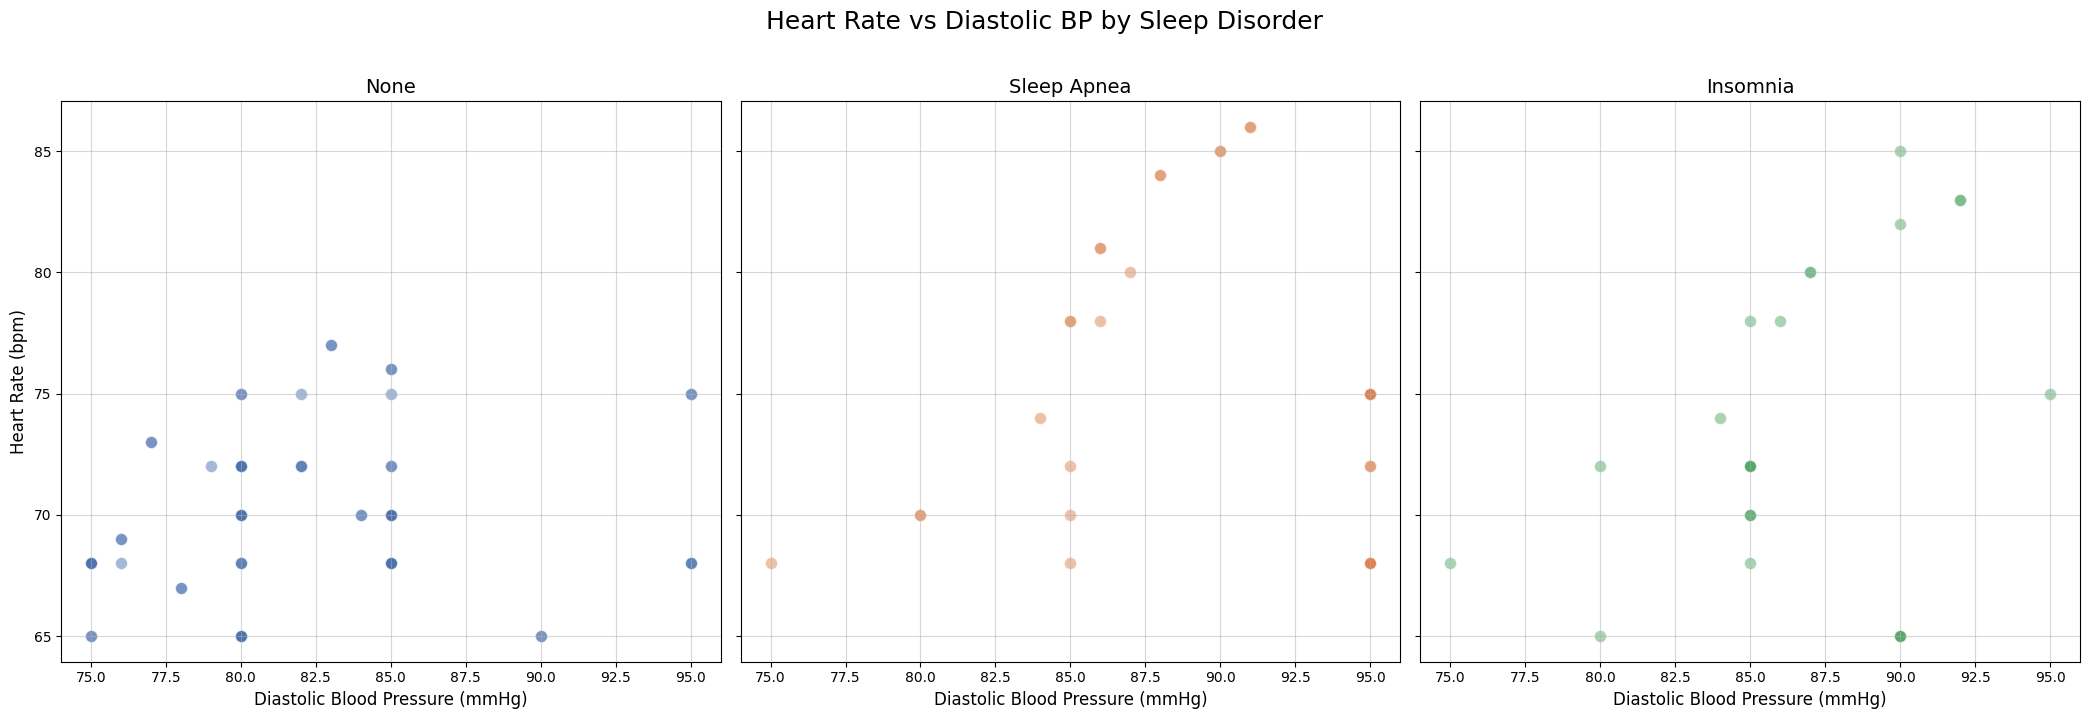

In [ ]:
#Define categories list so that the plotting order remains constant.
disorder_categories = ['None', 'Sleep Apnea', 'Insomnia']

fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)
plt.suptitle('Heart Rate vs Diastolic BP by Sleep Disorder', fontsize=18, y=1.02)

for i, category in enumerate(disorder_categories):
    ax = axs[i]
    subset_data = sleep_data[sleep_data['Sleep Disorder'] == category]
    sns.scatterplot( x='Diastolic BP', y='Heart Rate', data=subset_data, alpha=0.5, s=75, ax=ax, color=sns.color_palette('deep')[i])

    # Set title and labels for each subplot
    ax.set_title(f'{category}', fontsize=14)
    ax.set_xlabel('Diastolic Blood Pressure (mmHg)', fontsize=12) # Consistent label
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12) # Consistent label
    ax.grid(axis='both', alpha=0.5)

plt.tight_layout()
plt.show()

The incidence of sleep disorders also varies based on the BMI of an individual. Below, we plot the proportion of patients in the dataset who have no sleep disorder, sleep apnea, and insomnia by their BMI category (normal, overweight, or obese).

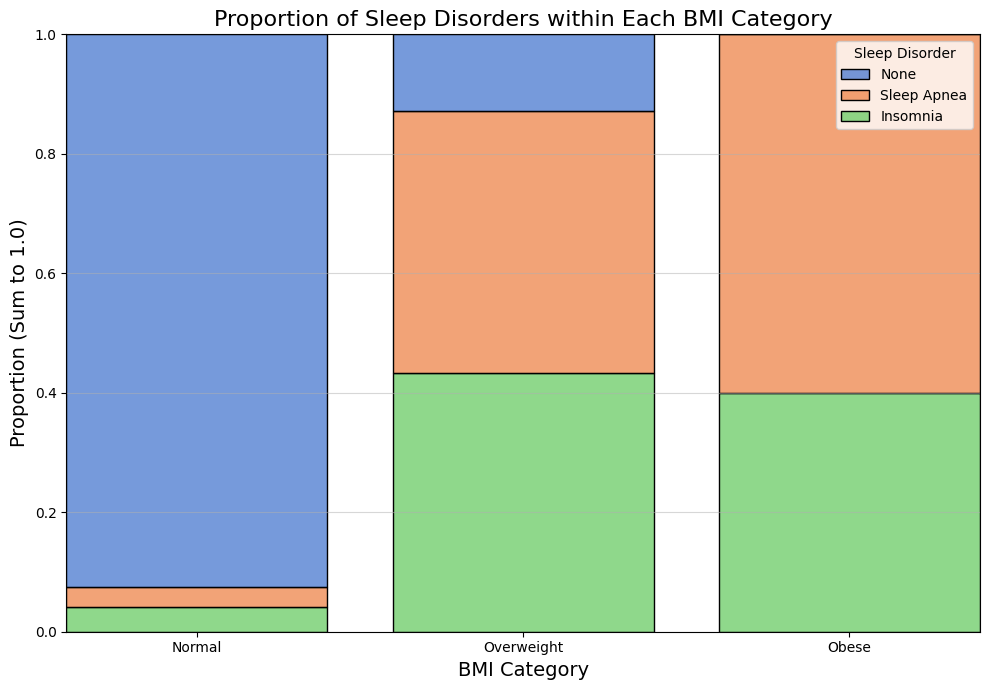

In [ ]:
#Turns out that normal bmi was represented in the data set as normal weight AND normal. I convert all normal weights to normal
sleep_data['BMI Category'] = sleep_data['BMI Category'].replace('Normal Weight', 'Normal')
bmi_order = ['Normal', 'Overweight', 'Obese']

#Converts BMI category data to categorical variable type so that the ordering stays the same during plotting
sleep_data['BMI Category'] = pd.Categorical( sleep_data['BMI Category'], categories=bmi_order, ordered=True)
plt.figure(figsize=(10, 7))

#Generates Plot
ax = sns.histplot(data=sleep_data, x="BMI Category", hue="Sleep Disorder", multiple="fill", discrete=True, shrink=.8, ax=plt.gca())

plt.title('Proportion of Sleep Disorders within Each BMI Category', fontsize=16)
plt.xlabel('BMI Category', fontsize=14)
plt.ylabel('Proportion (Sum to 1.0)', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Since individuals with sleep disorders receive more varied sleep (typically less sleep) than those without sleep disorders, we plot the duration of sleep by the different categories of sleep disorders.

<Axes: xlabel='Sleep Disorder', ylabel='Sleep Duration'>

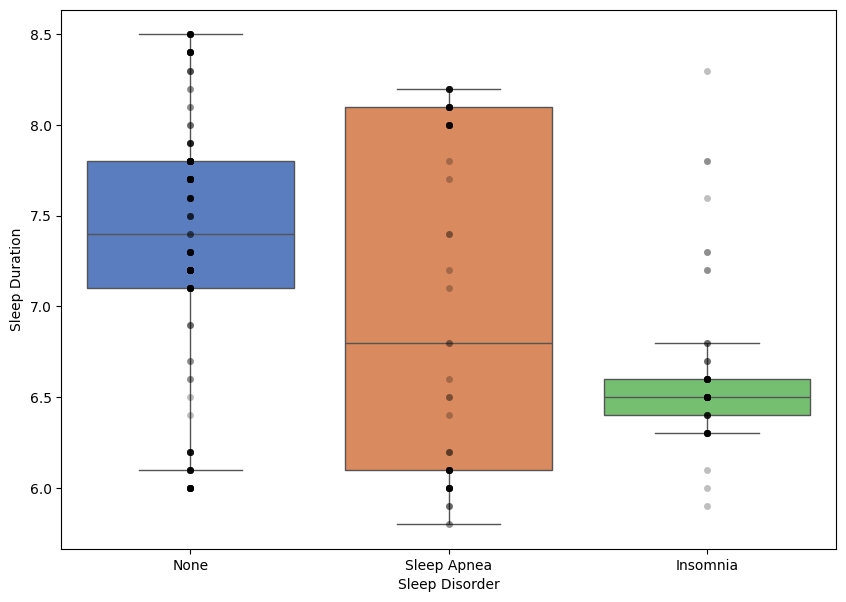

In [ ]:
disorder_order = ['None', 'Sleep Apnea', 'Insomnia', ]

#Generates Plot
plt.figure(figsize=(10, 7))
sns.boxplot( x='Sleep Disorder', y='Sleep Duration', data=sleep_data, order=disorder_order, hue='Sleep Disorder', showfliers=False, ax=plt.gca())
sns.stripplot(x='Sleep Disorder', y='Sleep Duration', data=sleep_data, order=disorder_order, size=5, color='black', alpha=0.25, jitter=False, ax=plt.gca())

Finally, we generate a correlation heatmap, which correlates each of the patient variables with each other. Looking at the results specifically for Sleep Disorder_Insomnia, Sleep Disorder_None and Sleep Disorder_Sleep Apnea reveals which of the factors may be most useful in predicting the occurance of these different conditions.

In [ ]:
#One Hot Encode Categorical variables including sleep disorder, gender, and BMI Category
sleep_data_encoded = pd.get_dummies(
    sleep_data,
    columns=['Sleep Disorder', 'Gender', 'BMI Category'],
    prefix=['Sleep Disorder', 'Gender', 'BMI Category'],
    dtype=int
)

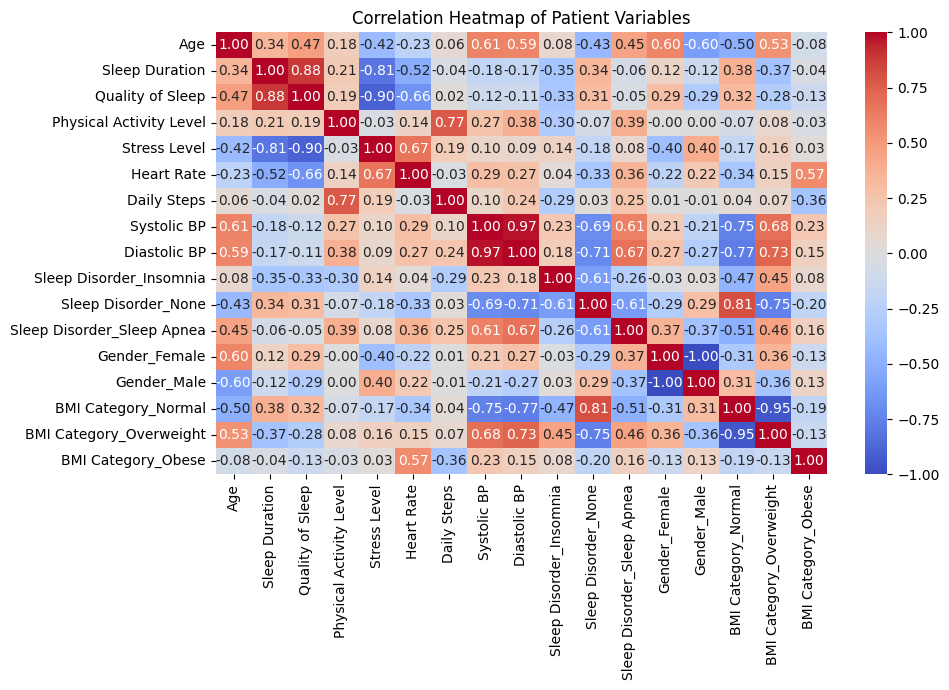

In [ ]:
#Generates correlation heatmap for each of the measured variables.
numeric_df = sleep_data_encoded.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 7))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Patient Variables')
    plt.tight_layout()
    plt.show()

# Section 3: Predicting the Occurance of Sleep Apnea or Insomnia
Now, we train a PyTorch neural network model to perform multi-class classification (0 = none, 1 = sleep apnea, 2 = insomnia) using the same data as before. The data is split 80%-20%, training-testing. I will then evaluate the accuracy of the model.

In [ ]:
#Target columns are the variables we are trying to predict (i.e, Sleep Disorder)
target_cols = ['Sleep Disorder_None', 'Sleep Disorder_Insomnia', 'Sleep Disorder_Sleep Apnea']
X = sleep_data_encoded.drop(columns=target_cols).values #Drops sleep disorder data from input variables
Y = sleep_data_encoded[target_cols].values #Keeps sleep disorder data as output data

#Scales data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converts X and y to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(Y, dtype=torch.float32)

# Split data 80-20 train-test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=0) #Random state = 0 for reproduceability

In [ ]:
# Two hidden layers (specified in the hw)
layers = [
    torch.nn.Linear(X_train.shape[1], 64), # maps to 64 neurons
    torch.nn.ReLU(), #first layer
    torch.nn.Linear(64, 32), # maps 64 neurons to 32 neurons
    torch.nn.ReLU(), #second layer
    torch.nn.Linear(32, y_train.shape[1]) # maps 32 neurons to one price output
]

model = torch.nn.Sequential(*layers) #passing the different layers (from above) into the model.
lossmod = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) # loss and optimizing functions, learning rate set to 0.05 because of overfitting


--- Training Model (14 inputs, 64 -> 32 hidden layers, 3 outputs) ---
Epoch [20/100], Loss: 0.2606
Epoch [40/100], Loss: 0.2351
Epoch [60/100], Loss: 0.2240
Epoch [80/100], Loss: 0.2528
Epoch [100/100], Loss: 0.2252


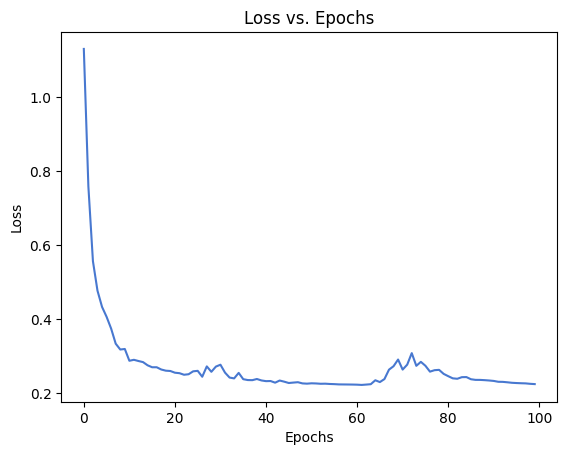

In [ ]:
epochs = 100 #Epochs lowered from 500 -> 100 because of spike in loss due to overfitting
losslist = []
epochslist = []

print(f"\n--- Training Model ({X_train.shape[1]} inputs, 64 -> 32 hidden layers, 3 outputs) ---")

for epoch in range(epochs):
    model.train() #Set model to training mode
    optimizer.zero_grad()  # Zero the gradients
    logits = model(X_train)  # Forward pass to get logits
    loss = lossmod(logits, y_train.argmax(dim=1)) #loss calculations
    loss.backward() # Backward pass and optimization
    optimizer.step() # Update weights
    epochslist.append(epoch) #store epoch
    losslist.append(loss.item())  # Store loss

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

#Plot epochs and loss
plt.plot(epochslist, losslist)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.show()

In [ ]:
# Evaluate the model
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    y_test_pred = model(X_test)  # Get predictions
    _, predicted_classes = torch.max(y_test_pred, 1)  # Predicted classes
    _, true_classes = torch.max(y_test, 1)  # True classes

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
auc_roc = roc_auc_score(y_test.numpy(), y_test_pred.numpy(), multi_class='ovr')

# Print evaluation results
print(f"Test Accuracy (20% split): {accuracy:.4f}")
print(f"Test Precision (20% split): {precision:.4f}")
print(f"Test Recall (20% split): {recall:.4f}")
print(f"Test F1 Score (20% split): {f1:.4f}")
print(f"Test AUC-ROC (20% split): {auc_roc:.4f}")

Test Accuracy (20% split): 0.9067
Test Precision (20% split): 0.9056
Test Recall (20% split): 0.9067
Test F1 Score (20% split): 0.9052
Test AUC-ROC (20% split): 0.8882


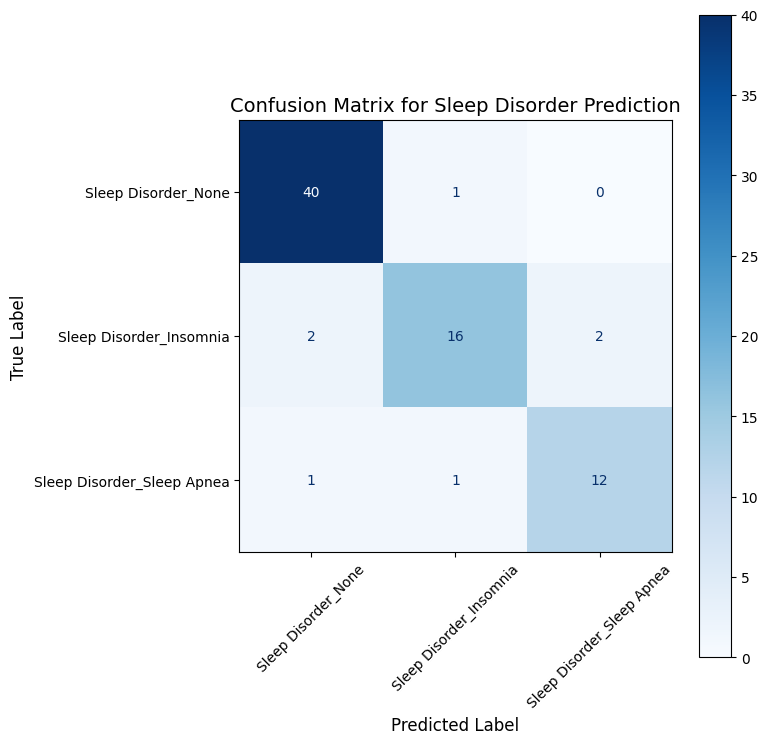

In [ ]:
# Convert tensors to numpy arrays for sklearn
predicted_classes_np = predicted_classes.cpu().numpy()
true_classes_np = true_classes.cpu().numpy()

# Compute the Confusion Matrix
cm = confusion_matrix(true_classes_np, predicted_classes_np)

# Visualize the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_cols)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Plot Confusion Matrix
ax.set_title('Confusion Matrix for Sleep Disorder Prediction', fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()